In [1]:
# Part 2.1 Data Splitting

import random

# Create random number list
total = 47
temp = list(range(total))

final = []
for i in range(total):
    r = random.randint(0,len(temp)-1)
    final.append(temp.pop(r))

# Divide list into 3 sets based on standard
train_nums = final[0:28] # 60% of total
val_nums = final[28:37] # 20% of total
test_nums = final[37:46] # 20% of total

import os
import shutil

# If data folder exists, delete
if os.path.exists('data/'):
    shutil.rmtree('data/')

classes = ["A",'B','C','D','E','F','G','H','I']

# Create train/val/test folders and class folders
os.makedirs('data')

os.makedirs('data/train')
for i in range(len(classes)):
    os.makedirs('data/train/'+str(i))
    
os.makedirs('data/val')
for i in range(len(classes)):
    os.makedirs('data/val/'+str(i))
    
os.makedirs('data/test')
for i in range(len(classes)):
    os.makedirs('data/test/'+str(i))

# Go thru images and copy according to previous divisions
fileList = os.listdir('sample/')

for i in fileList:
    cur_split = i.split('_')
    
    for j in train_nums:
        if cur_split[1]==str(j):
            shutil.copy('sample/'+i,'data/train/'+\
                        str(classes.index(cur_split[2]))+'/')
    
    for j in val_nums:
        if cur_split[1]==str(j):
            shutil.copy('sample/'+i,'data/val/'+\
                        str(classes.index(cur_split[2]))+'/')
    
    for j in test_nums:
        if cur_split[1]==str(j):
            shutil.copy('sample/'+i,'data/test/'+\
                        str(classes.index(cur_split[2]))+'/')

In [2]:
# Part 2.2 Convolutional Network
# Please see comments right of the code for explanation

import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv2d(3,5,5)
        self.pool = nn.MaxPool2d(4,4)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(5,10,4)
        self.fc1 = nn.Linear(10*5*5,32)
        self.fc2 = nn.Linear(32,9)
    def forward(self,x): # start with 3x224x224 image
        x = self.pool(x) # pooling by 4x4 to 3x56x56
        
        x = self.pool(F.relu(self.conv1(x))) # convoluted layer to 5x52x52
        # ReLu activation, pooling by 4x4 to 5x13x13
        x = self.pool1(F.relu(self.conv2(x))) # convoluted layer to 10x10x10
        # ReLu activation, pooling by 2x2 to 10x5x5
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x)) # fully connected layer, ReLu activation, 32 channels
        x = self.fc2(x) # fully connected layer, 9 channels
        return x

# Total 4 layers, based on convolution + fully connected layer lecture exmaple

In [3]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler

#image_size = 224
#batch_size = 80
root = 'C:/Users/Karl2/Desktop/2019 Winter/APS360 AI/A3/'
transform = tv.transforms.ToTensor()

train_set = tv.datasets.ImageFolder(root=root+'data/train/',transform=transform)
val_set = tv.datasets.ImageFolder(root=root+'data/val/',transform=transform)
test_set = tv.datasets.ImageFolder(root=root+'data/test/',transform=transform)

In [10]:
# From nn.ipynb

import torch.optim as optim
import matplotlib.pyplot as plt

train_acc_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_acc_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

def get_accuracy(model, train=False):
    if train:
        data = train_set
    else:
        data = val_set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total



def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            optimizer.zero_grad()         # a clean up step for PyTorch

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))

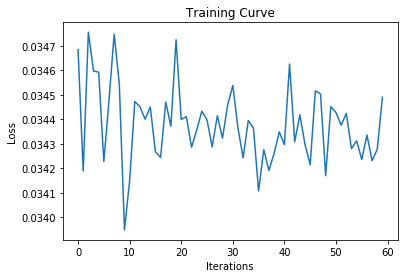

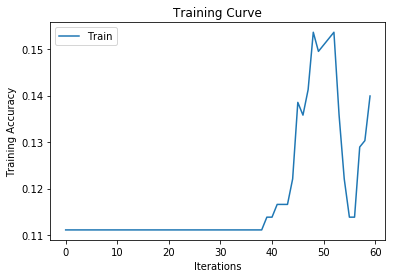

In [11]:
# Part 2.3 Training
model = Classifier()
train(model, train_set, num_epochs=5)

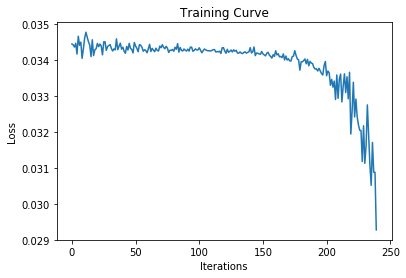

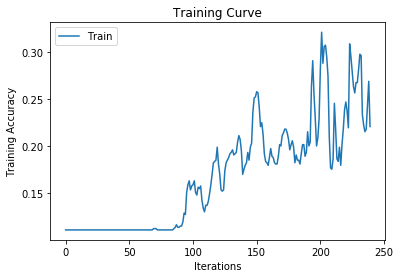

In [12]:
# Part 2.4 Hyper-parameter search

# 1: num_epoch to improve results
model = Classifier()
train(model, train_set, num_epochs=20)

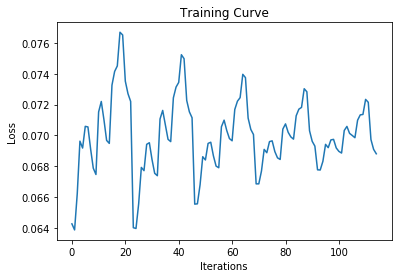

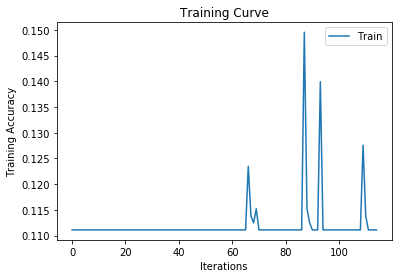

In [13]:
# 2: batch_size to improve results
# From nn.ipynb

import torch.optim as optim
import matplotlib.pyplot as plt

train_acc_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_acc_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

def get_accuracy(model, train=False):
    if train:
        data = train_set
    else:
        data = val_set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=32):
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total



def train(model, data, batch_size=32, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            optimizer.zero_grad()         # a clean up step for PyTorch

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
model = Classifier()
train(model, train_set, num_epochs=5)

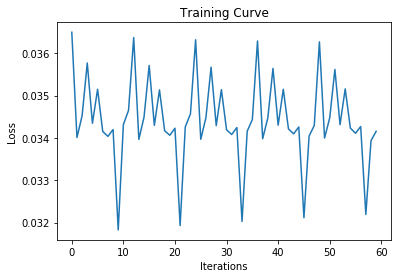

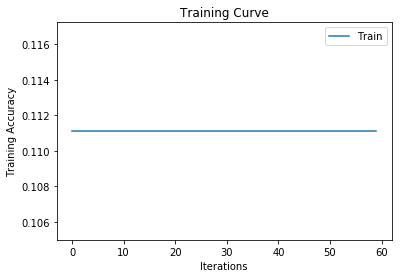

In [14]:
# 3: lr (learning rate) to reduce loss noise
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            optimizer.zero_grad()         # a clean up step for PyTorch

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))

model = Classifier()
train(model, train_set, num_epochs=5)

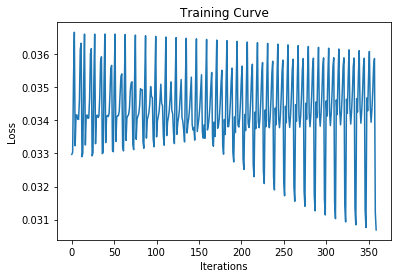

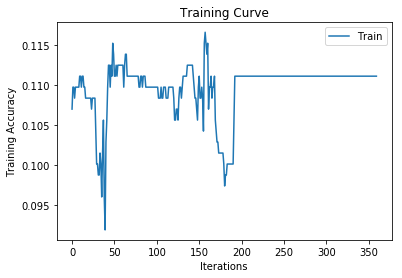

In [15]:
# 4: further adjust num_epoch to improve results
model = Classifier()
train(model, train_set, num_epochs=30)

# The best model is number 1 because it has the best loss and accuracy results
# The best test accuracy is 0.3

In [47]:
# Part 2.5 Transfer learning

from a3code import AlexNetFeatures
import numpy as np

myfeature_model = AlexNetFeatures()

img = train_set[0][0]
img = np.expand_dims(img.permute(0,1,2),axis=0)
alex_train = myfeature_model(torch.tensor(img))

In [65]:
# Part 2.2 Convolutional Network
# Please see comments right of the code for explanation

import torch
import torch.nn as nn
import torch.nn.functional as F

class Predicter(nn.Module):
    def __init__(self):
        super(Predicter,self).__init__()
        self.fc1 = nn.Linear(224*6*6,1000) # fully connected layer, 1000 channels
        self.fc2 = nn.Linear(1000,9) # fully connected layer, 9 channels
    def forward(self,x): # start with 3x224x224 image
        x = F.relu(self.fc1(x)) # fully connected layer, ReLu activation
        x = F.relu(self.fc2(x)) # fully connected layer
        return x

# Total 2 layers, since AlexNet already did training, only fully connected
# layers are needed to correlated to end results

def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        i = 0
        for imgs in iter(train_loader):
            imgs2, labels = list(torch.utils.data.DataLoader(train_set, batch_size=batch_size))[i]
            i+=1
            
            optimizer.zero_grad()         # a clean up step for PyTorch

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))

predicter = Predicter()
output = train(predicter, alex_train, batch_size=64, num_epochs=5)

RuntimeError: size mismatch, m1: [1536 x 6], m2: [8064 x 1000] at c:\a\w\1\s\tmp_conda_3.6_070023\conda\conda-bld\pytorch-cpu_1544079880394\work\aten\src\th\generic/THTensorMath.cpp:940

In [64]:
alex_train.shape
# adjust num_epoch
# adjust batch_size
# adjust lr

torch.Size([1, 256, 6, 6])